# Pokemon Po

## Naive Pokemon-catching strategy

In [285]:
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import csv

In [286]:
walking_speed = 0.129 # blocks/min

In [287]:
df = pd.read_csv('Providence_Pokemon_1.csv', names = ["xCoord", "yCoord", "points", "time"])
df = df[:-1] # remove 0 row
df.head()

,xCoord,yCoord,points,time
0,3,1,12,0
1,7,2,6,34
2,10,6,4,70
3,4,10,3,104
4,8,3,1,140


The function `simpleAlgorithm` takes in the current location, `current`, the walking speed, `speed`, and a dataset `pokeData`. It returns the number of Pokemon caught and their total point value using a naive Pokemon-catching strategy.

In [317]:
def simpleAlgorithm(current_location, speed, pokeData):
    pokemon_caught = 0
    points = 0
    time = 0
    for index, row in pokeData.iterrows():
        pokemon_location = (row["xCoord"], row["yCoord"])
        arrival_time = row["time"]
        possible_time = min(arrival_time + 15 - time, 15)
        within_range, travel_time = inRange(current_location, pokemon_location, possible_time, speed)
        if within_range:
            pokemon_caught += 1
            points += row["points"]
            time += travel_time
            current_location = pokemon_location
        else:
            time = arrival_time
    return pokemon_caught, points

The function `inRange` determines whether you can make it from the starting coordinates, `start`, to the ending coordinates, `end`, in `time` minutes or less. If so, it returns 1 and the amount of time required. If not, it returns (0, 0).

In [289]:
def inRange(start, end, time, speed):
    xDist = abs(end[0] - start[0])
    yDist = abs(end[1] - start[1])
    elapsed = (xDist + yDist)/speed
    if elapsed <= time:
        return 1, elapsed
    else:
        return 0, 0

##### Test case for `simpleAlgorithm`

In [292]:
testData = [[1, 1, 5 , 0],
            [1, 2, 3 , 1],
            [2, 2, 22, 1.5],
            [2, 1, 10, 2],
            [1, 2, 1 , 3]]
testdf = pd.DataFrame(testData, columns = ["xCoord", "yCoord", "points", "time"])
testdf

,xCoord,yCoord,points,time
0,1,1,5,0.0
1,1,2,3,1.0
2,2,2,22,1.5
3,2,1,10,2.0
4,1,2,1,3.0


In [293]:
simpleAlgorithm((1,1), 1/15, testdf)

(3, 9.0)

## Exploratory data analysis

In [295]:
node_score = np.zeros((12, 12))
for index, row in df.iterrows():
    node_score[row["xCoord"], row["yCoord"]] += row["points"]

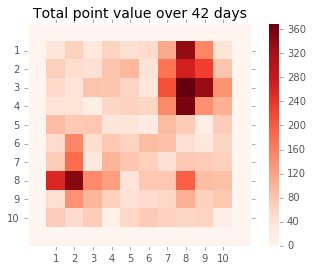

In [296]:
plt.style.use('ggplot')
fig = plt.gca()
fig.set_aspect('equal')
fig.set_xticks(np.array([1,2,3,4,5,6,7,8,9,10]) + 0.5)
fig.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
fig.set_yticks(np.array([1,2,3,4,5,6,7,8,9,10]) + 0.5)
fig.set_yticklabels([1,2,3,4,5,6,7,8,9,10])
fig.invert_yaxis()
fig.set_title("Total point value over 42 days", size=14)
plt.pcolor(node_score ,cmap=plt.cm.Reds)
plt.colorbar()
#plt.show()
#plt.savefig("totalPoint.png")
plt.savefig('right orientation.pdf', format='pdf')

In [297]:
node_number = np.zeros((12, 12))
for index, row in df.iterrows():
    node_number[row["xCoord"], row["yCoord"]] += 1

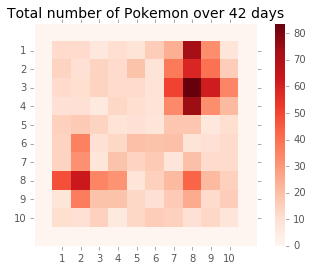

In [298]:
plt.style.use('ggplot')
fig = plt.gca()
fig.set_aspect('equal')
fig.set_xticks(np.array([1,2,3,4,5,6,7,8,9,10]) + 0.5)
fig.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
fig.set_yticks(np.array([1,2,3,4,5,6,7,8,9,10]) + 0.5)
fig.invert_yaxis()
fig.set_yticklabels([1,2,3,4,5,6,7,8,9,10])
fig.set_title("Total number of Pokemon over 42 days", size=14)
plt.pcolor(node_number ,cmap=plt.cm.Reds)
plt.colorbar()
#plt.show()
plt.savefig("totalNumber.png", padinches=0)

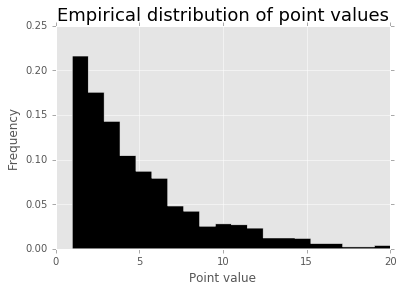

In [299]:
plt.style.use('ggplot')
plt.hist(df["points"], bins=20, histtype='stepfilled', normed=True, color='black')
plt.title("Empirical distribution of point values", size=18)
plt.xlabel("Point value")
plt.ylabel("Frequency")
plt.savefig("Spmf.png")

In [300]:
timeBetween = np.zeros(len(df["time"]) - 1)
for i in range(len(df["time"])):
    if i == len(df["time"])-1:
        break
    timeBetween[i] = df["time"][i+1] - df["time"][i]

In [301]:
len(timeBetween)

1998

In [302]:
mu = np.mean(timeBetween)
sigma2 = np.var(timeBetween)
y = mlab.normpdf(np.linspace(0,70,1000), mu, np.sqrt(sigma2))

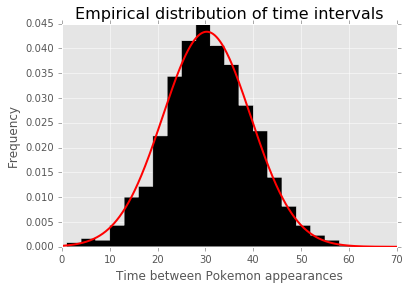

In [303]:
plt.style.use('ggplot')
plt.hist(timeBetween, bins=20, histtype='stepfilled', normed=True, color='black')
plt.title("Empirical distribution of time intervals", size=16)
plt.xlabel("Time between Pokemon appearances")
plt.ylabel("Frequency")
plt.plot(np.linspace(0,70,1000), y, 'r-', linewidth=2)
plt.savefig("interval_hist.png")

## Improved model informed by above results

In [309]:
def complicatedAlgorithm(current_location, speed, pokeData, scoring):
    pokemon_caught = 0
    points = 0
    time = 0
    maxTime = max(pokeData["time"])
    while time < maxTime:
        pokemon_on_board = pokeData[(pokeData["time"] <= time) & (pokeData["time"] >= time - 15)]
        bestPoints = 0
        target_node = best_node(current_location[0], current_location[1], scoring)
        for index, row in pokemon_on_board.iterrows():
            pokemon_location = [row["xCoord"], row["yCoord"]]
            if pokemon_location == current_location:
                pokemon_caught += 1
                points += row["points"]
                pokeData = pokeData.drop(index)
                pokemon_on_board = pokemon_on_board.drop(index)
            else:
                arrival_time = row["time"]
                possible_time = min(arrival_time + 15 - time, 15)
                within_range, travel_time = inRange(current_location, pokemon_location, possible_time, speed)
                if within_range and row["points"] > bestPoints:
                    bestPoints = row["points"]
                    target_node = pokemon_location
                    
        # move toward target node
        if current_location[0] != target_node[0]:
            current_location[0] += np.sign(target_node[0] - current_location[0])
        else:
            current_location[1] += np.sign(target_node[1] - current_location[1])
        time += 1/speed # add time required to cross edge
        
    return pokemon_caught, points

In [321]:
def globalAlgorithm(current_location, speed, pokeData):
    pokemon_caught = 0
    points = 0
    time = 0
    maxTime = max(pokeData["time"])
    while time < maxTime:
        pokemon_on_board = pokeData[(pokeData["time"] <= time) & (pokeData["time"] >= time - 15)]
        bestPoints = 0
        target_node = [3,8]
        for index, row in pokemon_on_board.iterrows():
            pokemon_location = [row["xCoord"], row["yCoord"]]
            if pokemon_location == current_location:
                pokemon_caught += 1
                points += row["points"]
                pokeData = pokeData.drop(index)
                pokemon_on_board = pokemon_on_board.drop(index)
            else:
                arrival_time = row["time"]
                possible_time = min(arrival_time + 15 - time, 15)
                within_range, travel_time = inRange(current_location, pokemon_location, possible_time, speed)
                if within_range and row["points"] > bestPoints:
                    bestPoints = row["points"]
                    target_node = pokemon_location
        
        # move toward target node
        if current_location[0] != target_node[0]:
            current_location[0] += np.sign(target_node[0] - current_location[0])
        else:
            current_location[1] += np.sign(target_node[1] - current_location[1])
        time += 1/speed # add time required to cross edge
        
    return pokemon_caught, points

In [311]:
def best_node(x, y, scoring):
    left = scoring[x - 1, y]
    right = scoring[x + 1, y]
    down = scoring[x, y - 1]
    up = scoring[x, y + 1]
    best = max(left, right, down, up)
    if best == left:
        return (x-1, y)
    elif best == right:
        return (x+1, y)
    elif best == down:
        return (x, y-1)
    elif best == up:
        return (x, y+1)

## Cross-validation

In [328]:
k = 10
partition_size = len(df)/k
complicated_results = []
simple_results = []
global_results = []
for i in range(k):
    train_data = pd.concat([df.iloc[0: int(i * partition_size)],
                            df.iloc[int((i+1) * partition_size): len(df)]])
    test_data = df.iloc[int(i * partition_size) : int((i+1) * partition_size)]
    min_time = min(test_data["time"])
    max_time = max(test_data["time"])
    interval = max_time - min_time
    
    score = np.zeros((12, 12))
    for index, row in train_data.iterrows():
        score[row["xCoord"], row["yCoord"]] += row["points"]
    n, t = complicatedAlgorithm([5,5], walking_speed, test_data, score)
    complicated_results.append([n / interval * 12*60, t / interval * 12*60])
    n, t = simpleAlgorithm([5,5], walking_speed, test_data)
    simple_results.append([n / interval * 12*60, t / interval * 12*60])
    n, t = globalAlgorithm([5,5], walking_speed, test_data)
    global_results.append([n / interval * 12*60, t / interval * 12*60])

In [329]:
complicated_results

[[3.5128071092524831, 16.936748562467329],
 [3.2492060839043959, 15.403643657028249],
 [4.0342781806196442, 14.950560316413975],
 [1.7857142857142856, 8.2142857142857135],
 [0.7122835943940643, 2.1368507831821928],
 [3.548606390210741, 17.865397688647178],
 [0.8393005828476271, 3.5970024979184014],
 [3.0703624733475481, 15.58799409545678],
 [2.4383164005805513, 8.2438316400580547],
 [1.5276644361024974, 6.4631956912028734]]

In [330]:
simple_results

[[0.75274438055410342, 2.1327757449032934],
 [0.60170483035266586, 2.045796423199064],
 [0.59327620303230066, 2.0171390903098221],
 [1.3095238095238095, 3.9285714285714279],
 [1.3058532563891181, 4.9859851607584496],
 [0.36709721278042151, 0.9789259007477904],
 [1.0791007493755205, 2.877601998334721],
 [1.0628177792356899, 5.0779071674594061],
 [1.0449927431059507, 1.9738751814223512],
 [0.58756324465480658, 4.2304553615146077]]

In [331]:
global_results

[[3.8891792995295349, 18.567694720334554],
 [3.8509109142570623, 16.125689453451447],
 [4.8648648648648649, 19.696769940672382],
 [4.0476190476190474, 20.0],
 [2.9678483099752677, 15.195383347073374],
 [3.7933378653976888, 19.456152277362339],
 [4.3164029975020819, 23.38051623646961],
 [3.8969985238641951, 20.429719534197147],
 [3.2510885341074021, 10.101596516690856],
 [2.1152276807573038, 11.046188999510363]]